In [23]:
import pandas as pd
import numpy as np
import joblib
import os
import sys
from pathlib import Path

path = Path(os.getcwd()).resolve().parent.parent
if path not in sys.path:
    sys.path.append(str(path))

import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score
from src.data.save_results import save_model_scores, save_model_predictions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from src.utils.data_loader import load_preprocessed_data
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline

In [24]:
DATA = path / "data"
TRAINED_DATA = DATA / "trained_data"
MODELS = DATA / "models"

In [28]:
METHOD = "SingleOutput"

cv_scorings = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

target_variable = "rain"

data = load_preprocessed_data(method=METHOD, target_variable="rain")

X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]
preprocessor = data["preprocessor"]

y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

lgbmc_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LGBMClassifier(class_weight='balanced'))
])

MODEL_PATH = MODELS / "LGBMClassifier"
if not MODEL_PATH.exists():
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_TARGET_PATH = MODEL_PATH / f"LGBMC_{target_variable}.pkl"
if MODEL_TARGET_PATH.exists():
    lgbmc_pipeline = joblib.load(MODEL_TARGET_PATH)
else:
    # Train and evaluate on test set
    lgbmc_pipeline.fit(X_train, y_train_binary)
    joblib.dump(lgbmc_pipeline, MODEL_TARGET_PATH)


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


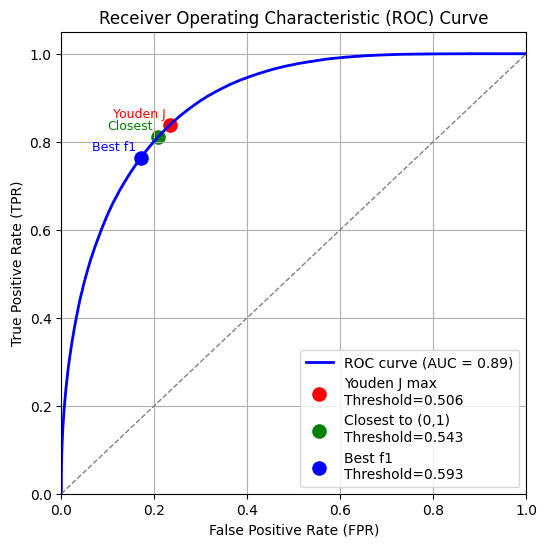

In [40]:
y_train_pred_proba_lgbmc = lgbmc_pipeline.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train_binary, y_train_pred_proba_lgbmc)
roc_auc = auc(fpr, tpr)

# 1. Youden’s J statistic = max(TPR - FPR)
youden_idx = np.argmax(tpr - fpr)
youden_threshold = thresholds[youden_idx]
youden_point = (fpr[youden_idx], tpr[youden_idx])

# 2. Điểm gần (0,1) nhất trên ROC (min khoảng cách Euclid)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
closest_idx = np.argmin(distances)
closest_threshold = thresholds[closest_idx]
closest_point = (fpr[closest_idx], tpr[closest_idx])

f1_thresholds = np.linspace(0.0, 1.0, num=200)
f1_scores = []
for threshold in f1_thresholds:
    preds = (y_train_pred_proba_lgbmc >= threshold).astype(int)
    f1_scores.append(f1_score(y_train_binary, preds))

best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = f1_thresholds[best_f1_idx]
closest_idx = np.argmin(np.abs(thresholds - best_f1_threshold))
closest_best_f1_threshold = thresholds[closest_idx]
best_f1_point = (fpr[closest_idx], tpr[closest_idx])

# Vẽ biểu đồ ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Đường tham chiếu (random)

# Đánh dấu 2 điểm ngưỡng
plt.scatter(*youden_point, color='red', s=90, label=f'Youden J max\nThreshold={youden_threshold:.3f}')
plt.scatter(*closest_point, color='green', s=90, label=f'Closest to (0,1)\nThreshold={closest_threshold:.3f}')
plt.scatter(*best_f1_point, color='blue', s=90, label=f'Best f1\nThreshold={closest_best_f1_threshold:.3f}')

# Ghi nhãn điểm
plt.text(youden_point[0] - 0.01, youden_point[1] + 0.01, f'Youden J', color='red', fontsize=9,
         verticalalignment='bottom', horizontalalignment='right')
plt.text(closest_point[0] - 0.01, closest_point[1] + 0.01, f'Closest', color='green', fontsize=9,
         verticalalignment='bottom', horizontalalignment='right')
plt.text(best_f1_point[0] - 0.01, best_f1_point[1] + 0.01, f'Best f1', color='blue', fontsize=9,
         verticalalignment='bottom', horizontalalignment='right')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [33]:
print(f"Số lượng ngưỡng: {len(thresholds)}")
print(f"Các ngưỡng đầu tiên: {thresholds[:10]}")


Số lượng ngưỡng: 150607
Các ngưỡng đầu tiên: [       inf 0.99732348 0.99731405 0.99730639 0.99707417 0.99704552
 0.99675957 0.99675751 0.99659222 0.99658214]


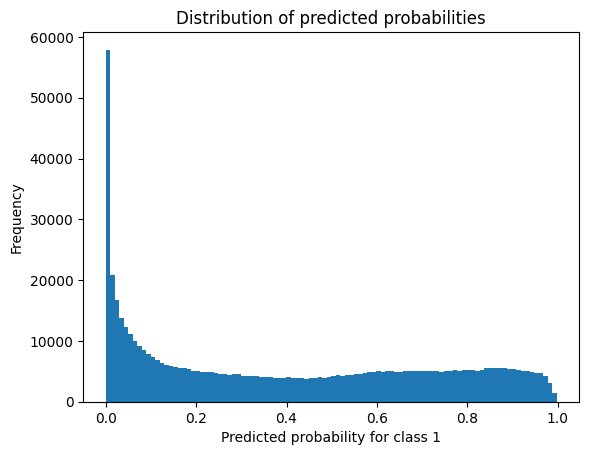

In [34]:
plt.hist(y_train_pred_proba_lgbmc, bins=100)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Predicted probability for class 1")
plt.ylabel("Frequency")
plt.show()

In [37]:

y_pred_proba_lgbmc = lgbmc_pipeline.predict_proba(X_test)[:, 1]
y_pred_lgbmc = (y_pred_proba_lgbmc >= closest_threshold).astype(int)

accuracy_lgbmc = accuracy_score(y_test_binary, y_pred_lgbmc)
f1_lgbmc = f1_score(y_test_binary, y_pred_lgbmc)
roc_auc_lgbmc = roc_auc_score(y_test_binary, y_pred_proba_lgbmc)

tscv = TimeSeriesSplit(n_splits=3)

cv_results = {}
for name, scoring in cv_scorings.items():
    scores = cross_val_score(lgbmc_pipeline, X_train, y_train_binary, cv=tscv, scoring=scoring)
    cv_results[name] = (np.mean(scores), np.std(scores))

# Transform X_train via preprocessor to calculate VIF
X_train_transformed = preprocessor.fit_transform(X_train)
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

X_vif = pd.DataFrame(X_train_transformed)
vif_data = pd.DataFrame()
vif_data["feature_index"] = range(X_vif.shape[1])
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])] # type: ignore

# === Print results ===
print(f"[RESULT] LGBM Classifier - {target_variable}")
print("Cross-Validation Scores:")
for name, (mean_score, std_score) in cv_results.items():
    print(f"  [{name}]: {mean_score:.2f} ± {std_score:.2f}")

print(classification_report(y_test_binary, y_pred_lgbmc))
print("\nTest Set Evaluation:")
print(f"  [Accuracy]: {accuracy_lgbmc:.2f}")
print(f"  [F1]: {f1_lgbmc:.2f}")
print(f"  [ROC-AUC]: {roc_auc_lgbmc:.2f}")
print("\n[VIF Scores]")
print(vif_data.sort_values("VIF", ascending=False).head(20))

# === Save results ===
PATH = DATA / "scores&predictions" / METHOD / f"{target_variable}_classifier"

save_model_scores(
    model_name="LGBMClassifier",
    save_dir=PATH,
    category="classifier",
    accuracy=accuracy_lgbmc,
    f1=f1_lgbmc,
    roc_auc=roc_auc_lgbmc,
    cv_accuracy_mean=cv_results["accuracy"][0],  # mean RMSE
    cv_accuracy_std=cv_results["accuracy"][1],  # std RMSE
    cv_f1_mean=cv_results["f1"][0],  # mean MAE
    cv_f1_std=cv_results["f1"][1],  # std MAE
    cv_roc_auc_mean=cv_results["roc_auc"][0],  # mean R2
    cv_roc_auc_std=cv_results["roc_auc"][1]  # std R2
)

save_model_predictions("LGBMClassifier", y_test, y_pred_lgbmc, PATH)


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 47191, number of negative: 102362
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 149553, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 92369, number of negative: 206734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1729
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 132031, number of negative: 316622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1733
[LightGBM] [Info] Number of data points in the train set: 448653, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 47191, number of negative: 102362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 149553, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 92369, number of negative: 206734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1729
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 132031, number of negative: 316622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1733
[LightGBM] [Info] Number of data points in the train set: 448653, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 47191, number of negative: 102362
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 149553, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 92369, number of negative: 206734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1729
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 132031, number of negative: 316622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1733
[LightGBM] [Info] Number of data points in the train set: 448653, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RESULT] LGBM Classifier - rain
Cross-Validation Scores:
  [accuracy]: 0.77 ± 0.02
  [f1]: 0.66 ± 0.03
  [roc_auc]: 0.88 ± 0.00
              precision    recall  f1-score   support

           0       0.90      0.81      0.85    112122
           1       0.57      0.74      0.64     37429

    accuracy                           0.79    149551
   macro avg       0.74      0.78      0.75    149551
weighted avg       0.82      0.79      0.80    149551


Test Set Evaluation:
  [Accuracy]: 0.79
  [F1]: 0.64
  [ROC-AUC]: 0.87

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3               3  2.694716
0               0  2.655588
9               9  2.574975
8               8  2.533521
10             10  2.142527
6               6  2.019605
7               7  1.777153
12             12  1.766127
4               4  1.320416
5               5  1.237504
11             11  1.094703
